# Survival Analysis with Neural Networks

The provided dataset [`MG.sav`](MG.sav) contains the survival data of 1,802 patients with chronic heart failure.

|Variable|Description|
|:--|:--|
|PatientID|Unique ID for each patient.|
|Cohort|There are three cohorts of patients in the dataset, as follows:|
||· Cohort 1: Patients admitted to the hospital for heart failure between January 2007 and September 2008.|
||· Cohort 2: Patients admitted to the hospital for heart failure between September 2008 and December 2011.|
||· Cohort 3: Patients admitted to the hospital for heart failure between February 2012 and July 2014.|
|MaleSex|“1” if the patient is male, “0” if the patient is female.|
|Diabetes|Whether or not the patient has diabetes.|
|Stroke|Whether or not the patient has had a stroke.|
|COPD|Whether or not the patient has Chronic-Obstructive Pulmonary Disease (COPD).|
|SHFIsch|Whether or not the patient has a Family History of Ischemic Heart Failure (IHF). IHF is a heart muscle disease caused by a reduced blood supply to the heart. Ischemia is pain due to decreased oxygen (less oxygen delivered to the heart) (reversible). Infarction is the part(s) of heart muscles that have died (irreversible).|
|SHFValvular|Whether or not the patient has a Family History of valvular heart disease (VHD). The valve does not open or close (it does not function properly).|
|SHFHyper|Whether or not the patient has a Family History of Hypertension (High Blood Pressure).|
|SHFDCM|Whether or not the patient has a Family History of Dilated Cardiomyopathy (DCM). The heart becomes big and flaccid – does not contract properly (links to cardio-thoracic ratio).|
|PPMorICD|Whether or not the patient has a pacemaker or an implantable cardioverter defibrillator (ICD). A pacemaker is a small device implanted in the chest to monitor the heart rhythm and deliver an electric shock to the heart if needed to restore a normal rhythm. An ICD is a small device implanted in the chest to monitor the heart rhythm.|
|ICD|Whether or not the patient has an ICD.|
|CRT|Whether or not the patient has undergone Cardiac Resynchronization Therapy (CRT). CRT is a treatment for heart failure that uses a pacemaker-like device to help the heart beat more efficiently.|
|ClinicDate|Date of the clinic visit (the first date of follow-up).|
|DeathDate|Date of death (if applicable).|
|CensorDate|Date of censoring (the last date of follow-up).|
|StatusDeath|Whether or not the patient died.|
|TimeDeath|Time to death (in days).|
|HFHospPrevYr|Whether or not the patient was hospitalised for heart failure in the previous year.|
|AnyHospOneYr|Whether or not the patient was hospitalised for any reason in the previous year.|
|CardHospOneYr|Whether or not the patient was hospitalised for cardiac reasons in the previous year.|
|HFHospOneYr|Whether or not the patient was hospitalised for heart failure in the previous year.|
|AnyHospNumbers|Number of hospitalisations in the previous year.|
|AnyHospTotalDays|The total number of days spent in the hospital in the previous year.|
|ClinicAge|Age of patient at clinic visit (in years).|
|NYHAclass|New York Heart Association (NYHA) classification of heart failure:|
||· Class I: No limitation on physical activity|
||· Class II: Slight limitation of physical activity|
||· Class III: Marked limitation of physical activity.|
||· Class IV: Unable to conduct any physical activity without discomfort|
|BP_Systolic|Systolic blood pressure (mmHg – millimetres of mercury).|
|BP_Diastolic|Diastolic blood pressure (mmHg – millimetres of mercury).|
|ECG_HeartRate|Heart rate (beats per minute).|
|ECG_PRinterval|The PR interval between the ECG P wave's beginning and the QRS complex's beginning (in milliseconds). The atria contract and the blood flows into the ventricles.|
|ECG_QRSinterval|QRS interval is the time between the ECG beginning of the QRS complex and the end of the QRS complex (in milliseconds). The right ventricle contracts, and the blood flows to the lung. The left ventricle contracts, and the blood flows to the rest of the body.|
|ECG_QTcinterval|QTc interval is the time between the ECG beginning of the QRS complex and the end of the T wave (in milliseconds). Ventricles contract, and the blood flows to the rest of the body. Time from contraction of ventricles until relaxation of ventricles (whole heartbeat).|
|Haemoglobin|Haemoglobin concentration (g/dL – grams per decilitre).|
|WCC|White blood cell count (103/µL – thousands per cubic microlitre).|
|Platelet|Platelet count (103/µL - thousands per cubic microlitre). More than 450,000 platelets result in a condition called thrombocytosis. Less than 150,000 is known as thrombocytopenia.|
|Na|Sodium concentration (mEq/L – milliequivalents per litre).|
|K|Potassium concentration (mEq/L – milliequivalents per litre).|
|Creatinine|Creatinine concentration (mg/dL – milligram per decilitre).|
|eGFR|Estimated glomerular filtration rate (eGFR) (mL/min – millilitres per minute).|
|Urea|Urea concentration (mg/dL – milligram per decilitre).|
|ALT|Alanine aminotransferase concentration (U/L – units per litre).|
|Albumin|Albumin concentration (g/L – grams per litre).|
|Urate|Urate concentration (g/L – grams per litre).|
|Glucose|Glucose concentration (mmol/L – millimoles per litre).|
|TSH|Thyroid stimulating hormone concentration.|
|fT4|Free thyroxine 4 concentration (pmol/L – picomoles per litre).|
|TotChol|Total cholesterol concentration (mmol/L – millimoles per litre).|
|ech_LAenlarged|Whether or not the left atrium is enlarged.|
|ech_IVSd|Interventricular septum diameter (mm – millimetres). Septal is the depth of the wall between ventricles.|
|ech_PWd|Posterior wall diameter (mm – millimetres).|
|ech_WallThMean|Mean wall thickness (mm – millimetres).|
|ech_LVEDD|Left ventricular end-diastolic diameter (LVEDD) (mm – millimetres). End-diastolic diameter is the diameter of the left ventricle at the end of diastole (relaxation).|
|ech_LVESD|Left ventricular end-systolic diameter (LVESD) (mm – millimetres). End-systolic diameter is the diameter of the left ventricle at the end of systole (contraction).|
|ech_EjectionFraction|The ejection fraction is the percentage of blood pumped out of the left ventricle with each contraction.|
|ech_LVHpresent|Whether or not left ventricular hypertrophy is present.|
|ech_PAP|Pulmonary artery pressure (mmHg – millimetres of mercury).|
|ech_RWMA|Whether or not there is right wall motion abnormality.|
|ech_RHEnlarged|Whether or not the right heart is enlarged. The right heart is enlarged mainly if the right ventricle is enlarged.|
|Holter_NSVT|Whether or not the patient has non-sustained ventricular tachycardia. Holter monitor test (continuous ECG usually over 24hr). A slow heart rate means bradycardia.|
|Holter_AF|Whether or not the patient has atrial fibrillation. Atrial fibrillation is an irregular and often rapid heart rate. The heart does not contract completely – it flutters. Contraction is not enough to push blood.|
|CardTHRatio|Cardiothoracic ratio. The ratio of the chest’s width to the chest’s height. A more significant percentage is worse.|
|PulOed|Whether or not the patient has pulmonary oedema. Pulmonary oedema is fluid in the lungs. Fluid in the lungs makes it hard to breathe – swelling of the lungs.|
|DietRx|Whether or not the patient is on diet treatment.|
|Sulphonylurea|Whether or not the patient is on a Sulphonylurea treatment – used to treat type 2 diabetes. |
|Insulin|Whether or not the patient is on insulin treatment. Externally given direct insulin (mutually exclusive with metformin). Insulin is a hormone that helps the body use glucose for energy.|
|Metformin|Whether or not the patient is on metformin treatment – given to people with diabetes to increase insulin in the body (mutually exclusive with insulin treatment) - used to treat type 2 diabetes.|
|Glitazone|Whether or not the patient is on a glitazone treatment – to treat type 2 diabetes. They may not need insulin or metformin.|
|Ace|Whether or not the patient is on an angiotensin-converting enzyme inhibitor  (ACE) treatment – used to treat high blood pressure.|
|AIIRB|Whether or not the patient is on an angiotensin II receptor blocker (AIIRB) treatment – used to treat high blood pressure.|
|ACEiARB|Whether or not the patient is on an ACE AAIRB treatment.|
|RamiprilEquiv|Whether or not the patient is on a ramipril equivalent treatment – used to treat high blood pressure.|
|Aspirin|Whether or not the patient is on aspirin treatment – used to treat high blood pressure.|
|BB|Whether or not the patient is on a beta-blocker treatment – used to treat high blood pressure.|
|BisoprololEquiv|Whether or not the patient is on a bisoprolol equivalent treatment – used to treat high blood pressure.|
|DiurLoop|Whether or not the patient is on a loop diuretic treatment. Loop diuretic (water pills) is to treat high blood pressure. Affects the loop part of the nephron in the kidney.|
|MRA|Whether or not the patient is on a mineralocorticoid receptor antagonist treatment – used to treat high blood pressure.|
|DiurLoopDose|Loop diuretic dose (mg – milligrams).|
|DiurLoopAndThiazide|Whether or not the patient is on both loop diuretic and thiazide treatments.|
|Statin|Whether or not the patient is on statin treatment – used to control cholesterol levels.|
|Warfarin|Whether or not the patient is on warfarin treatment. Warfarin is a blood thinner used to treat blood clots.|
|NYHADelta|Change in NYHA classification. NYHA classification is a classification system for heart failure:|
||1. no symptoms|
||2. slight symptoms|
||3. moderate symptoms|
||4. severe symptoms|
|NYHAworsening|Whether or not the patient's NYHA classification worsened after treatment.|
|NYHAimproving|Whether or not the patient's NYHA classification improved after treatment.|
|eGFRDelta|Change in eGFR. The glomerular part of the kidney’s nephron filters blood to remove wasteful substances (e.g. urea and creatinine).|
|LVEDDDelta|Change in LVEDD (mm – millimetres). Difference between left ventricular end-diastolic diameter at 12 months and left ventricular end-diastolic diameter at three months after treatment.|
|LVESDDelta|Change in LVESD (mm – millimetres). Difference between left ventricular end-systolic diameter at 12 months and left ventricular end-systolic diameter at three months after treatment.|
|LVESDremodel|Change in LVESD remodelling (mm – millimetres). Difference between measurement at 12 months and three months after treatment. Remodelling is the change in the size of the heart.|
|EFDelta|Change in ejection fraction – the difference between measurement at 12 months and three months after treatment.|

## Introduction

For an analysis done as part of his PhD thesis, John Mbotwa reduced the this dataset to PatientID with six covariates: 'Diabetes', 'StatusDeath', 'TimeDeath', 'ClinicDeath', 'Haemoglobin','Sex'. The full dataset was presented in an '*sav* file called 'MG HF cohorts 1 to 3 May 2016 censored.sav', here renamed to 'MG.sav' because of the white space in the title. (de Kamps, 2022)

## Data preparation

The first common sense check is see whether all covariates in John's 'FinalData' spreadsheet are present and whether the units makes sense. This is a ten year study and the time units report in the 'FinalData' spreadsheet seem days since start of study. (de Kamps, 2022)

In [1]:
import pandas as pd
import numpy as np

# Define path to the dataset
mg = 'MG.sav'

In [2]:
# Read the dataset into a pandas dataframe
df = pd.read_spss('MG.sav')

# Print the first 5 rows of the dataframe
df.head()

,PatientID,Cohort,MaleSex,Diabetes,Stroke,COPD,SHFIsch,SHFValvular,SHFHyper,SHFDCM,...,Statin,Warfarin,NYHADelta,NYHAworsening,NYHAimproving,eGFRDelta,LVEDDDelta,LVESDDelta,LVESDremodel,EFDelta
0,3.0,1.0,Male,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,1.0,Female,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2.449162,1.0,-2.0,95.652174,0.0
2,6.0,1.0,Male,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.386593,-2.0,-2.0,97.014925,2.0
3,7.0,1.0,Male,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,-4.662848,-8.0,-6.0,90.476190,0.0
4,9.0,1.0,Male,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### PatientId and Number of Entries

The `'FinalData'` spreadsheet lists 1802 rows, disregarding the data description line, with the `PatientId` ranging from 3 to 2540. The overall number of entries appears correct, but, annoyingly, the data seems to represented mainly as floats. (de Kamps, 2022)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1802 entries, 0 to 1801
Data columns (total 88 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   PatientID             1802 non-null   float64 
 1   Cohort                1802 non-null   float64 
 2   MaleSex               1802 non-null   category
 3   Diabetes              1802 non-null   float64 
 4   Stroke                1091 non-null   float64 
 5   COPD                  1802 non-null   float64 
 6   SHFIsch               1802 non-null   float64 
 7   SHFValvular           1091 non-null   float64 
 8   SHFHyper              1091 non-null   float64 
 9   SHFDCM                1091 non-null   float64 
 10  PPMorICD              1802 non-null   float64 
 11  ICD                   1802 non-null   float64 
 12  CRT                   1802 non-null   float64 
 13  ClinicDate            1802 non-null   object  
 14  DeathDate             1295 non-null   float64 
 15  Cens

### PatientID

`PatientID` contains entries consistent with `'FinalData'` spreadsheet. (de Kamps, 2022)

In [4]:
df['PatientID']

0          3.0
1          5.0
2          6.0
3          7.0
4          9.0
         ...  
1797    2532.0
1798    2533.0
1799    2534.0
1800    2535.0
1801    2540.0
Name: PatientID, Length: 1802, dtype: float64

### Diabetes

The first subject with Diabetes has `PatientID` 18. The floats can be converted to ints without problem. Again, this appears to match the `'FinalData'` spreadsheet. (de Kamps, 2022)

In [5]:
print(f'PatientID: {df["PatientID"][12]}\nDiabetes: {df["Diabetes"][12]}\n\n{df["Diabetes"]}')

PatientID: 18.0
Diabetes: 1.0

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1797    0.0
1798    1.0
1799    0.0
1800    0.0
1801    0.0
Name: Diabetes, Length: 1802, dtype: float64


### TimeDeath

`'TimeDeath'` matches the spreadsheet as well. Apparently, time of death in days since start of study. There are no missing values. (de Kamps, 2022)

In [6]:
print(f"Missing values in TimeDeath: {df['TimeDeath'].isna().sum()}")

df['TimeDeath']

Missing values in TimeDeath: 0


0       1961.0
1       2842.0
2        749.0
3       3378.0
4       3233.0
         ...  
1797     652.0
1798     652.0
1799     652.0
1800     652.0
1801     760.0
Name: TimeDeath, Length: 1802, dtype: float64

### StatusDeath

Again, good agreement with the `'FinalData'` spreadsheet. There are no missing values. (de Kamps, 2022)

In [7]:
# Target variable is "StatusDeath"
print(f"Missing values in StatusDeath: {df['TimeDeath'].isna().sum()}\n")

target = df['StatusDeath']
print(target)

Missing values in StatusDeath: 0

0       1.0
1       1.0
2       1.0
3       0.0
4       1.0
       ... 
1797    0.0
1798    0.0
1799    0.0
1800    0.0
1801    0.0
Name: StatusDeath, Length: 1802, dtype: float64


Visualising time of death for patients whose status is not 1.0. (de Kamps, 2022)

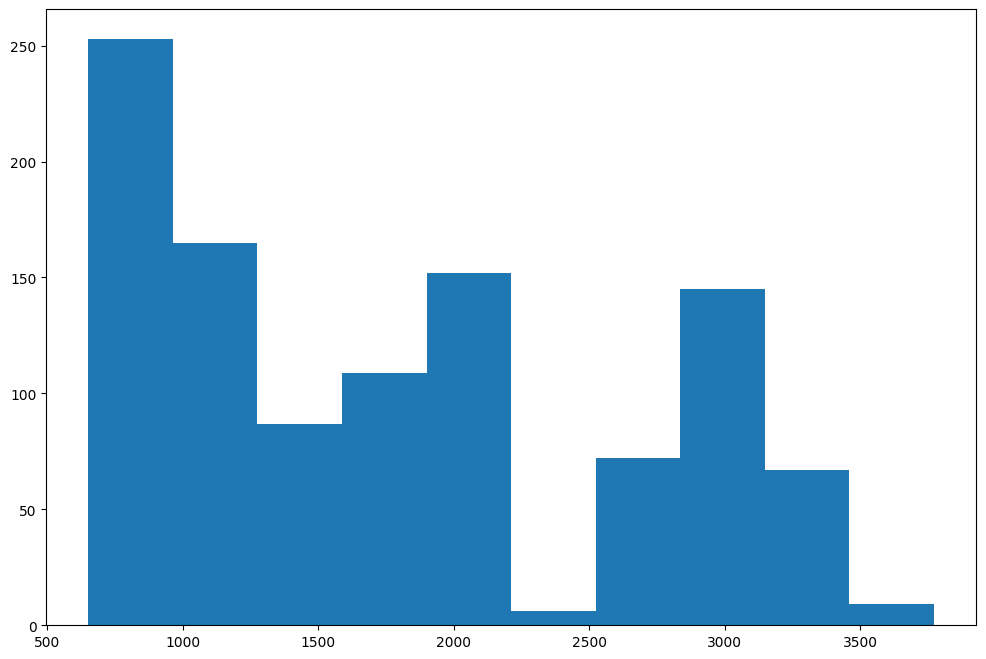

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# (de Kamps, 2022)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100  # 200 e.g. is really fine, but slower

timedeath = df['TimeDeath']
timedeath[target < 1.]
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.hist(timedeath[target < 1.])
plt.show()

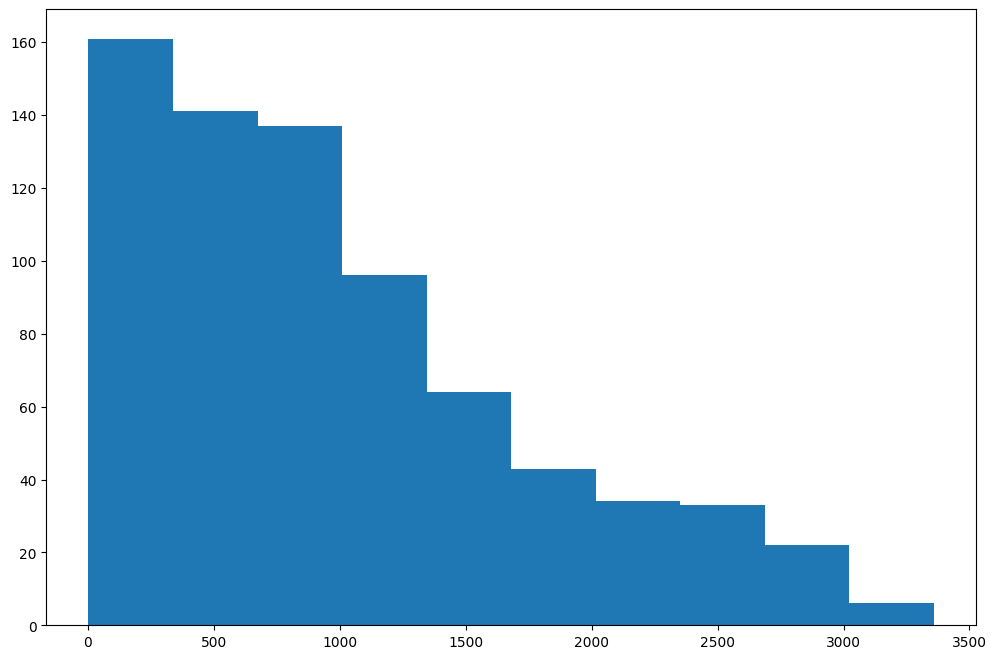

In [9]:
# (de Kamps, 2022)
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.hist(timedeath[target > 0.])
plt.show()

This is as expected. If someone truly died, they are very unlikely to live all the way up to 3650  days. It would be good to check if 'TimeDeath' corresponds to the end of study date for subjects entering the study after the starting date. (de Kamps, 2022)

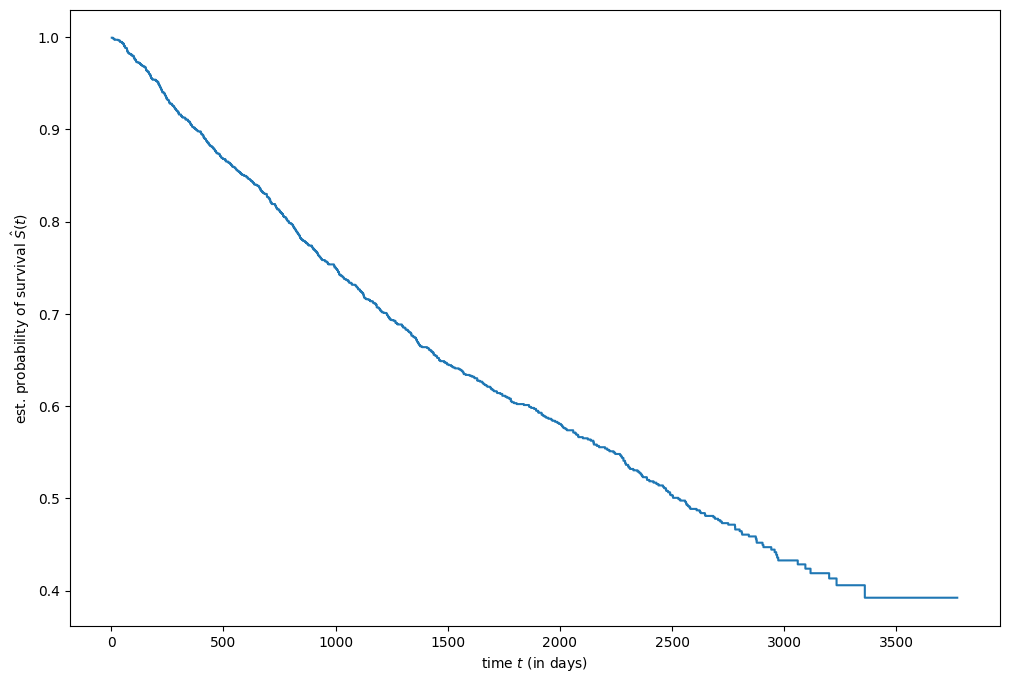

In [12]:
# (de Kamps, 2022)
from sksurv.nonparametric import kaplan_meier_estimator
statusdeath = [x > 0. for x in target]
time, survival_prob = kaplan_meier_estimator(statusdeath, df['TimeDeath'])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (in days)")
plt.show()

Let's bring the event data into the stuctured array that sksurv expects. (de Kamps, 2022)

In [13]:
import numpy as np

events = [ True if x > 0. else False for x in target]
times  = [ x for x in df['TimeDeath'] ]

data_y = np.array(list(zip(events,times)), dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
print(data_y)

[( True, 1961.) ( True, 2842.) ( True,  749.) ... (False,  652.)
 (False,  652.) (False,  760.)]


Let us now use the other covariates as mentioned by Mbotwa et al. (2021).

In [14]:
print(f"Missing values in ClinicAge: {df['ClinicAge'].isna().sum()}")
print(f"Missing values in Haemoglobin: {df['Haemoglobin'].isna().sum()}")

Missing values in ClinicAge: 0
Missing values in Haemoglobin: 6


We can impute the missing values for `'Haemoglobin'` with the mean value. (de Kamps, 2022)

In [15]:
data_x_withnan = df[['ClinicAge', 'Haemoglobin']]
data_x_numeric = data_x_withnan.fillna(data_x_withnan.mean())
print(data_x_numeric)
print(data_x_numeric.shape)

      ClinicAge  Haemoglobin
0          75.0         15.5
1          72.0         13.8
2          70.0         13.4
3          55.0         16.6
4          68.0         15.3
...         ...          ...
1797       83.0         13.7
1798       51.0         13.6
1799       72.0         15.7
1800       65.0         13.7
1801       87.0         12.6

[1802 rows x 2 columns]
(1802, 2)


As expected, there are no more missing values.

In [16]:
print(f"Missing values in ClinicAge: {data_x_numeric['ClinicAge'].isna().sum()}")
print(f"Missing values in Haemoglobin: {data_x_numeric['Haemoglobin'].isna().sum()}")

Missing values in ClinicAge: 0
Missing values in Haemoglobin: 0


In [17]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis()

In [18]:
estimator.score(data_x_numeric, data_y)

0.666426027639768

OK, let's add `'Diabetes'` and see if this improves the score (de Kamps, 2022). No problem with missing values: 

In [19]:
print(df['Diabetes'].isna().sum())

0


In [20]:
data_x_withnan3 = df[['ClinicAge', 'Haemoglobin', 'Diabetes']]
data_x_numeric3 = data_x_withnan3.fillna(data_x_withnan3.mean())
estimator3 = CoxPHSurvivalAnalysis()
estimator3.fit(data_x_numeric3, data_y)
estimator3.score(data_x_numeric3, data_y)

0.670451749959191

Now let's add gender. (de Kamps, 2022)

In [21]:
data_x_withnan4 = df[['ClinicAge', 'Haemoglobin', 'Diabetes', 'MaleSex']]
data_x_numeric4 = data_x_withnan4.fillna(data_x_withnan4.mean())
data_x_withnan4

C:\Users\omarc\AppData\Local\Temp\ipykernel_30948\2376980131.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_x_numeric4 = data_x_withnan4.fillna(data_x_withnan4.mean())


,ClinicAge,Haemoglobin,Diabetes,MaleSex
0,75.0,15.5,0.0,Male
1,72.0,13.8,0.0,Female
2,70.0,13.4,0.0,Male
3,55.0,16.6,0.0,Male
4,68.0,15.3,0.0,Male
...,...,...,...,...
1797,83.0,13.7,0.0,Male
1798,51.0,13.6,1.0,Male
1799,72.0,15.7,0.0,Male
1800,65.0,13.7,0.0,Male


The OneHotEncoder converts categorical data into numerical ones. (de Kamps, 2022)

In [22]:
from sksurv.preprocessing import OneHotEncoder

data_x_numeric4oh = OneHotEncoder().fit_transform(data_x_numeric4)
data_x_numeric4oh.head()

C:\Users\omarc\AppData\Roaming\Python\Python310\site-packages\sksurv\column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():


,ClinicAge,Haemoglobin,Diabetes,MaleSex=Male
0,75.0,15.5,0.0,1.0
1,72.0,13.8,0.0,0.0
2,70.0,13.4,0.0,1.0
3,55.0,16.6,0.0,1.0
4,68.0,15.3,0.0,1.0


In [23]:
estimator4 = CoxPHSurvivalAnalysis()
estimator4.fit(data_x_numeric4oh, data_y)
estimator4.score(data_x_numeric4oh, data_y)

0.679573425174674

Out of interest, what are the coefficients? (de Kamps, 2022)

In [24]:
print(estimator4.coef_)

[ 0.04359563 -0.19889853  0.30170977  0.56861131]


In [25]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
estimatorlasso = CoxnetSurvivalAnalysis(l1_ratio=0.99, fit_baseline_model=True)
estimatorlasso.fit(data_x_numeric4oh, data_y)
estimatorlasso.score(data_x_numeric4oh, data_y)

0.6795952666150136

In [26]:
from sksurv.svm import FastSurvivalSVM

estimatorsvm = FastSurvivalSVM(max_iter=1000, optimizer="rbtree", tol=1e-5, random_state=0)
estimatorsvm.fit(data_x_numeric4oh, data_y)
estimatorsvm.score(data_x_numeric4oh, data_y)

0.679901046779767

### Preliminary Conclusion

SVM, Cox proportional hazards and CPH with Lasso all seem to give similar results. We still have to do cross validation. (de Kamps, 2022)

## Implementation of the partial likelihood as a loss function

This is dual purpose. We can do a standard Cox PH regresssion and see if we agree on the result, but as a loss function it is also the output layer of Cox-NNet, so if it works, it shouldn't be hard to implement that network. (de Kamps, 2022)

The log partial likelihood id given by:
$$
\ln L_{\boldsymbol{\beta}} = \sum^N_{i=1} c_i( \theta_i - \ln \sum_{j \in R(t_j)} \exp \theta_j)
$$

When we allow for tied events, the procedure needs to be adapted. There are two main approaches, one by Breslow and one by Efron. Most survival analysis packages include at least these two methods. We will implement the Breslow one to ensure we understand the procedure, but will sksurv's implementation in the loss function. 

If $s_j=\sum_{i  \in D_j} \boldsymbol{x}_i$ is the sum of covariates over the set $D_j$ of individuals who die at time $t_j$, then
$$
L_{\boldsymbol{\beta}} = \frac{\Pi^J_{j=1} \exp \boldsymbol{\beta} \boldsymbol{s}_j}{ \left\{ \sum_{k \in R_j} \exp \boldsymbol{\beta} \boldsymbol{x}_k   \right\}^{d_j}}
$$

If we look at the file *coxph.py* we see that **CoxPHOptimizer** implements this likelihood.

In [27]:
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.
import torch
# import numbers
# import warnings

import numpy
# from scipy.linalg import solve
# from sklearn.base import BaseEstimator
# from sklearn.exceptions import ConvergenceWarning
# from sklearn.utils.validation import check_array, check_is_fitted

# from ..base import SurvivalAnalysisMixin
# from ..functions import StepFunction
# from ..nonparametric import _compute_counts
# from ..util import check_arrays_survival


class CoxPHOptimizer:
    """Negative partial log-likelihood of Cox proportional hazards model"""

    def __init__(self, X, event, time, alpha, ties):
        # sort descending
        o = numpy.argsort(-time, kind="mergesort")
        self.x = torch.tensor(X[o, :], dtype=torch.float)
        self.event = event[o]
        self.time = time[o]
        self.alpha = alpha
        # self.no_alpha = numpy.all(
        #     self.alpha < numpy.finfo(self.alpha.dtype).eps)
        if ties not in ("breslow", "efron"):
            raise ValueError("ties must be one of 'breslow', 'efron'")
        ties = "breslow"
        self._is_breslow = ties == "breslow"
        # self.hessian = None
        # self.gradient = None

    def nlog_likelihood(self, w):
        """Compute negative partial log-likelihood

        Parameters
        ----------
        w : array, shape = (n_features,)
            Estimate of coefficients

        Returns
        -------
        loss : float
            Average negative partial log-likelihood
        """
        time = self.time
        n_samples = self.x.shape[0]
        breslow = self._is_breslow
        xw = self.x@w

        loss = 0
        risk_set = 0
        k = 0
        while k < n_samples:
            ti = time[k]
            numerator = 0
            n_events = 0
            risk_set2 = 0
            while k < n_samples and ti == time[k]:
                if self.event[k]:
                    numerator = numerator + xw[k]
                    risk_set2 = risk_set2 + torch.exp(xw[k])
                    n_events = n_events + 1
                else:
                    risk_set = risk_set + torch.exp(xw[k])
                k = k + 1

            if n_events > 0:
                if breslow:
                    risk_set = risk_set + risk_set2
                    loss = loss - (numerator - n_events *
                                   torch.log(risk_set)) / n_samples
                else:
                    numerator = numerator/n_events
                    for _ in range(n_events):
                        risk_set = risk_set + risk_set2 / n_events
                        loss = loss - \
                            (numerator - torch.log(risk_set)) / n_samples

        # add regularization term to log-likelihood
        # return loss + torch.sum(self.alpha * torch.square(w)) / (2. * n_samples)
        return loss

    def update(self, w, offset=0):
        """Compute gradient and Hessian matrix with respect to `w`."""
        time = self.time
        x = self.x
        breslow = self._is_breslow
        exp_xw = numpy.exp(offset + numpy.dot(x, w))
        n_samples, n_features = x.shape

        gradient = numpy.zeros((1, n_features), dtype=w.dtype)
        hessian = numpy.zeros((n_features, n_features), dtype=w.dtype)

        inv_n_samples = 1. / n_samples
        risk_set = 0
        risk_set_x = numpy.zeros((1, n_features), dtype=w.dtype)
        risk_set_xx = numpy.zeros((n_features, n_features), dtype=w.dtype)
        k = 0
        # iterate time in descending order
        while k < n_samples:
            ti = time[k]
            n_events = 0
            numerator = 0
            risk_set2 = 0
            risk_set_x2 = numpy.zeros_like(risk_set_x)
            risk_set_xx2 = numpy.zeros_like(risk_set_xx)
            while k < n_samples and ti == time[k]:
                # preserve 2D shape of row vector
                xk = x[k:k + 1]

                # outer product
                xx = numpy.dot(xk.T, xk)

                if self.event[k]:
                    numerator += xk
                    risk_set2 += exp_xw[k]
                    risk_set_x2 += exp_xw[k] * xk
                    risk_set_xx2 += exp_xw[k] * xx
                    n_events += 1
                else:
                    risk_set += exp_xw[k]
                    risk_set_x += exp_xw[k] * xk
                    risk_set_xx += exp_xw[k] * xx
                k += 1

            if n_events > 0:
                if breslow:
                    risk_set += risk_set2
                    risk_set_x += risk_set_x2
                    risk_set_xx += risk_set_xx2

                    z = risk_set_x / risk_set
                    gradient -= (numerator - n_events * z) * inv_n_samples

                    a = risk_set_xx / risk_set
                    # outer product
                    b = numpy.dot(z.T, z)

                    hessian += n_events * (a - b) * inv_n_samples
                else:
                    numerator /= n_events
                    for _ in range(n_events):
                        risk_set += risk_set2 / n_events
                        risk_set_x += risk_set_x2 / n_events
                        risk_set_xx += risk_set_xx2 / n_events

                        z = risk_set_x / risk_set
                        gradient -= (numerator - z) * inv_n_samples

                        a = risk_set_xx / risk_set
                        # outer product
                        b = numpy.dot(z.T, z)

                        hessian += (a - b) * inv_n_samples

        if not self.no_alpha:
            gradient += self.alpha * inv_n_samples * w

            diag_idx = numpy.diag_indices(n_features)
            hessian[diag_idx] += self.alpha * inv_n_samples

        self.gradient = gradient.ravel()
        self.hessian = hessian

### Have we done this correctly?

An independent check on the numbers would be handy. John Fox introductory course on survival analysis, https://socialsciences.mcmaster.ca/jfox/Courses/soc761/survival-analysis.pdf, provides a numerical example. The advantage of that example is that we get to see which coefficient belongs to what covariate. (de Kamps, 2022)

In [29]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter

rossi = load_rossi()

cph = CoxPHFitter().fit(rossi, 'week', 'arrest')

cph.print_summary(columns=["coef", "se(coef)", "p"])

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2023-04-04 00:09:04 UTC

---
            coef   se(coef)      p
covariate                         
fin        -0.38       0.19   0.05
age        -0.06       0.02   0.01
race        0.31       0.31   0.31
wexp       -0.15       0.21   0.48
mar        -0.43       0.38   0.26
paro       -0.08       0.20   0.66
prio        0.09       0.03 <0.005
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

OK, that was a bit quick. What happened here? **Lifelines** is another survival package. It was just one line to do CoxPH fit and the coefficients are almost identical to the example given by Fox (slide 76). (de Kamps, 2022)

At the very least, we should redo the analysis with sksurv. *rossi* is a dataframe that is understood by Pandas.

In [30]:
print(rossi)

     week  arrest  fin  age  race  wexp  mar  paro  prio
0      20       1    0   27     1     0    0     1     3
1      17       1    0   18     1     0    0     1     8
2      25       1    0   19     0     1    0     1    13
3      52       0    1   23     1     1    1     1     1
4      52       0    0   19     0     1    0     1     3
..    ...     ...  ...  ...   ...   ...  ...   ...   ...
427    52       0    1   31     0     1    0     1     3
428    52       0    0   20     1     0    0     1     1
429    52       0    1   20     1     1    1     1     1
430    52       0    0   29     1     1    0     1     3
431    52       0    1   24     1     1    0     1     1

[432 rows x 9 columns]


In [31]:
# (de Kamps, 2022)
events = [True if x > 0. else False for x in rossi['arrest']]
times = [x for x in rossi['week']]

data_y_rossi = np.array(list(zip(events, times)), dtype=[
                        ('Status', '?'), ('Survival_in_weeks', '<f8')])

data_x_rossi = rossi[['fin','age','race','wexp','mar','paro','prio']]
print(data_x_rossi)

     fin  age  race  wexp  mar  paro  prio
0      0   27     1     0    0     1     3
1      0   18     1     0    0     1     8
2      0   19     0     1    0     1    13
3      1   23     1     1    1     1     1
4      0   19     0     1    0     1     3
..   ...  ...   ...   ...  ...   ...   ...
427    1   31     0     1    0     1     3
428    0   20     1     0    0     1     1
429    1   20     1     1    1     1     1
430    0   29     1     1    0     1     3
431    1   24     1     1    0     1     1

[432 rows x 7 columns]


In [32]:
# (de Kamps, 2022)
estimatorrossi = CoxPHSurvivalAnalysis()
estimatorrossi.fit(data_x_rossi, data_y_rossi)
score = estimatorrossi.score(data_x_rossi, data_y_rossi)
print('Estimator score is:', score)
print('Coefficients:', estimatorrossi.coef_)

Estimator score is: 0.6404231835047672
Coefficients: [-0.37902189 -0.05724593  0.31412977 -0.1511146  -0.43278257 -0.08498284
  0.09111154]


Again, very similar results to Fox's table and importantly, the order of the coefficients is given by the order of the covariates. (de Kamps, 2022)

Now let's go back for to the CHF data for a bit and see whether the lifelines analysis produces the same coefficients.

In [33]:
# (de Kamps, 2022)
data_chf = df[['StatusDeath', 'TimeDeath',
               'ClinicAge', 'Haemoglobin', 'Diabetes', 'MaleSex']]
data_chf_imputed = data_chf.fillna(data_chf.mean())
data_chf_numeric = OneHotEncoder().fit_transform(data_chf_imputed)
data_chf_numeric.head()

C:\Users\omarc\AppData\Local\Temp\ipykernel_30948\2981646489.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_chf_imputed = data_chf.fillna(data_chf.mean())
C:\Users\omarc\AppData\Roaming\Python\Python310\site-packages\sksurv\column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():


,StatusDeath,TimeDeath,ClinicAge,Haemoglobin,Diabetes,MaleSex=Male
0,1.0,1961.0,75.0,15.5,0.0,1.0
1,1.0,2842.0,72.0,13.8,0.0,0.0
2,1.0,749.0,70.0,13.4,0.0,1.0
3,0.0,3378.0,55.0,16.6,0.0,1.0
4,1.0,3233.0,68.0,15.3,0.0,1.0


In [34]:
# (de Kamps, 2022)
cphchf = CoxPHFitter().fit(data_chf_numeric, 'TimeDeath', 'StatusDeath')
cphchf.print_summary(columns=["coef", "se(coef)", "p"])
# Store the coefficients
cphchf_coef = cphchf.summary['coef']

<lifelines.CoxPHFitter: fitted with 1802 total observations, 1065 right-censored observations>
             duration col = 'TimeDeath'
                event col = 'StatusDeath'
      baseline estimation = breslow
   number of observations = 1802
number of events observed = 737
   partial log-likelihood = -4949.39
         time fit was run = 2023-04-04 00:09:05 UTC

---
               coef   se(coef)      p
covariate                            
ClinicAge      0.04       0.00 <0.005
Haemoglobin   -0.20       0.02 <0.005
Diabetes       0.30       0.08 <0.005
MaleSex=Male   0.57       0.09 <0.005
---
Concordance = 0.68
Partial AIC = 9906.77
log-likelihood ratio test = 329.17 on 4 df
-log2(p) of ll-ratio test = 230.07

They are almost the same coefficients, and in the same order. (de Kamps, 2022)

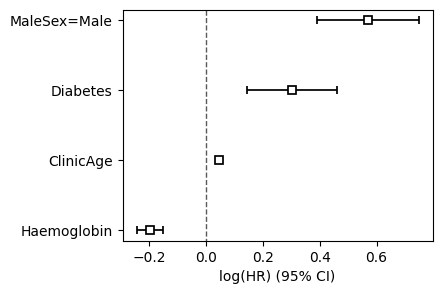

In [35]:
# Plot the coefficients
plt.figure(figsize=(4, 3))
cphchf.plot()
plt.show()

## Neural Network Implementation of Partial Regression

OK, we have a free floating loss function, as yet not really tested. It's not even a loss function as such, more a methodology. Let's tidy up. (de Kamps, 2022)

In [36]:
# (de Kamps, 2022)

import torch.nn

torch.autograd.set_detect_anomaly = True


class CoxNNet(torch.nn.Module):

    def __init__(self, df, censorvariablename, survivaltimevariablename, coefficients=None):

        super().__init__()

        self.covariates = [x for x in df.columns if x !=
                           censorvariablename and x != survivaltimevariablename]
        self.df = df
        self.dfx = df[self.covariates].to_numpy(dtype=float)

        if coefficients == None:
            n_covariates = len(self.covariates)
            self.coefficients = torch.randn(
                n_covariates, requires_grad=True, dtype=torch.float)
        else:
            self.coefficients = coefficients
        print(self.coefficients)
        # this line is used in coxpy to initialize the alphas
        alphas = torch.zeros(self.dfx.shape[1])
        self.opt = CoxPHOptimizer(self.dfx, self.df[censorvariablename].to_numpy(),
                                  self.df[survivaltimevariablename].to_numpy(),
                                  alphas, 'breslow')

    def forward(self):
        # sksurv calculates the llh /event and puts a minus sign in front, we undo that
        total = -self.df.shape[0]*self.opt.nlog_likelihood(self.coefficients)
        return total


c = torch.tensor([-0.38, -0.06, 0.31, -0.15, -0.43, -0.08, 0.09])
net = CoxNNet(rossi, 'arrest', 'week', coefficients=c)
net.forward()

tensor([-0.3800, -0.0600,  0.3100, -0.1500, -0.4300, -0.0800,  0.0900])


tensor(-659.1310)

In [37]:
# (de Kamps, 2022)
# Compare to a direct call
# this line is used in coxpy to initialize the alphas
alphas = np.zeros(data_x_rossi.shape[1], dtype=np.float_)
opt = CoxPHOptimizer(data_x_rossi.to_numpy(), rossi['arrest'].to_numpy(
), rossi['week'].to_numpy(), alphas, 'breslow')
print(opt.nlog_likelihood(c.detach().cpu().numpy()))
print('Comparable log partial llh estimate:')
print(-data_x_rossi.shape[0]*opt.nlog_likelihood(c.detach().cpu().numpy()))

tensor(1.5258)
Comparable log partial llh estimate:
tensor(-659.1310)


This is nearly identical to **lifelines** estimate. (de Kamps, 2022)

We can do the same for the CHF data.

### Implementing gradient descent and determining the maximum log partial likelihood.

In [38]:
# (de Kamps, 2022)
net = CoxNNet(rossi, 'arrest', 'week')
loss = net.forward()
print(loss)
lr = 0.0001
loss.backward()
n_epoch = 4000
for i in range(n_epoch):
    loss = net.forward()
    loss.backward()
    with torch.no_grad():
        net.coefficients += net.coefficients.grad * lr
        net.coefficients.grad.zero_()

loss = net.forward()
print(loss)
print(net.coefficients)

tensor([-0.0064,  0.6072,  0.5897, -0.9535,  0.7736, -1.0371, -0.2927],
       requires_grad=True)
tensor(-1742.6490, grad_fn=<MulBackward0>)
tensor(-659.1380, grad_fn=<MulBackward0>)
tensor([-0.3785, -0.0577,  0.3297, -0.1610, -0.3635, -0.0880,  0.0908],
       requires_grad=True)


Since the values found by CoxNNet for the coefficients appear close to the lifelines results, it appears we have successfully used *pytorch* to calculate a gradient for the loss function and perform steepest gradient descent. This means we can start building neural networks with it. (de Kamps, 2022)

## Concordance Statistics

## Visualising the data

We can also visualise the data.

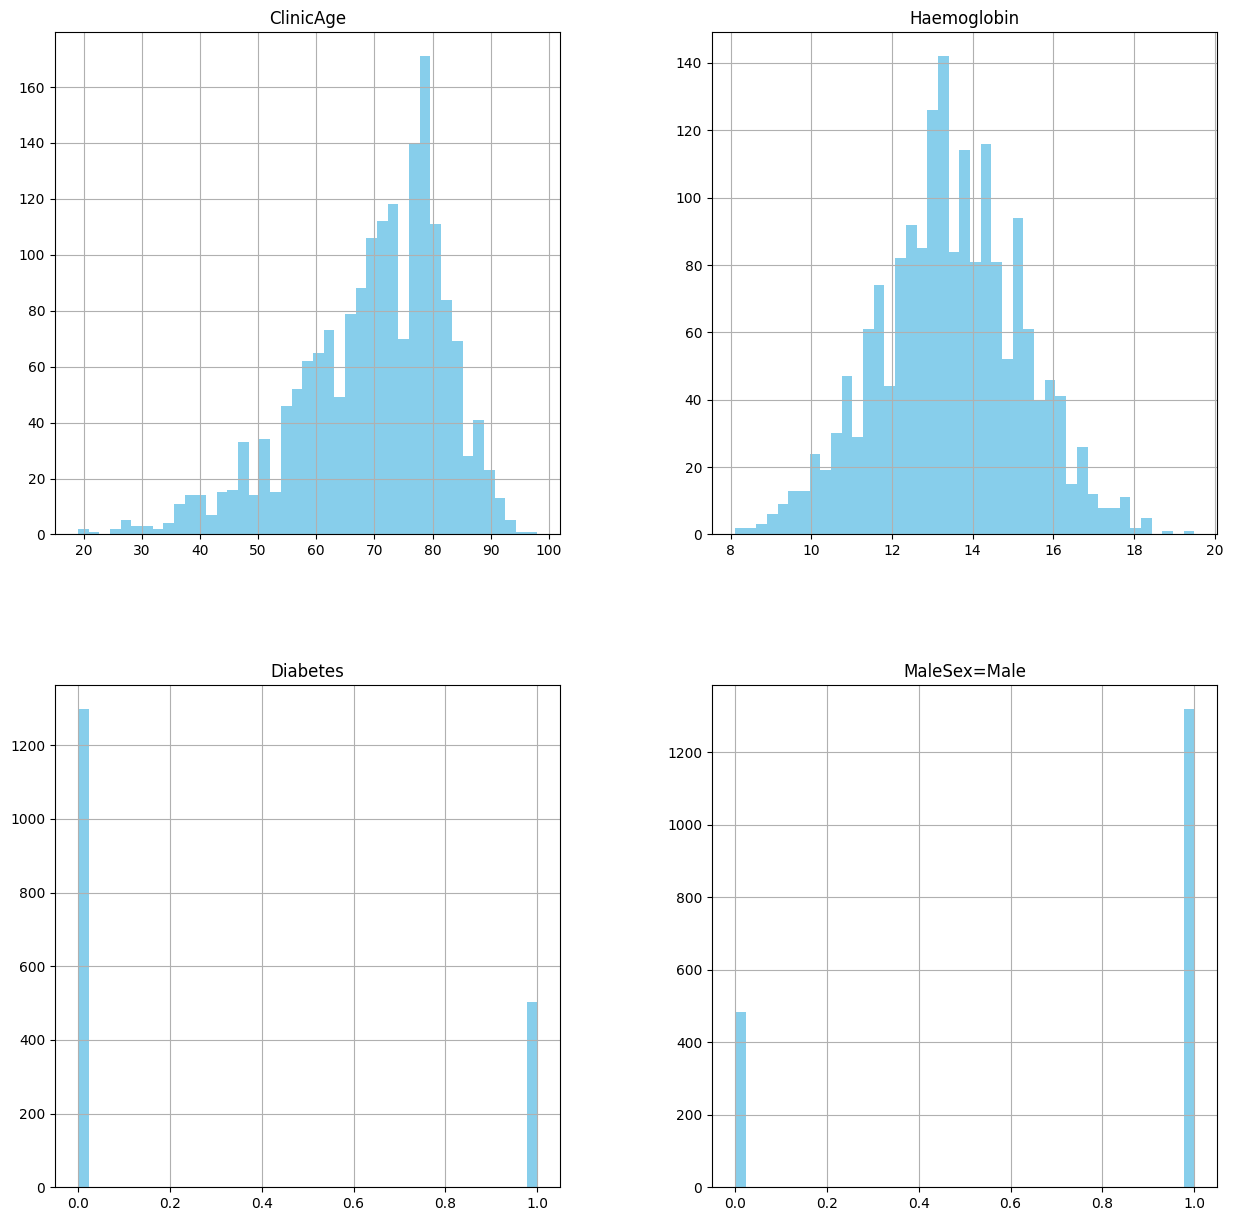

In [39]:
# Calculates number of bins for the histograms by taking the square root of the number of data points (comes out as 50)
n_bins = int(np.ceil(np.sqrt(data_x_numeric4oh.shape[0])))

# Plot histograms for each feature of interest
data_x_numeric4oh.hist(bins=n_bins, figsize=(15, 15), color='skyblue')
plt.show()

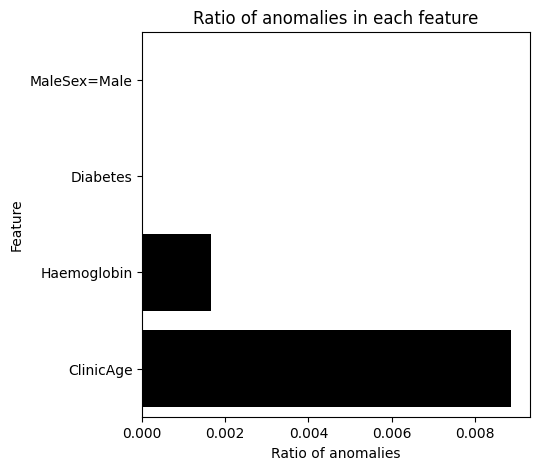

In [40]:
# Calculate standard deviation of each feature
std = data_x_numeric4oh.std()
outlier_upper_threshold = data_x_numeric4oh.mean() + 3*std
outlier_lower_threshold = data_x_numeric4oh.mean() - 3*std
# Calculate and plot the ratio of number of outliers to number of data in each feature
outlier_ratio = ((data_x_numeric4oh > outlier_upper_threshold).sum(
) + (data_x_numeric4oh < outlier_lower_threshold).sum())/data_x_numeric4oh.shape[0]
# Sort x axis by outlier ratio
outlier_ratio.sort_values(ascending=False, inplace=True)
outlier_ratio.plot(kind='barh', figsize=(5, 5))
# Horizontal black bars
plt.barh(outlier_ratio.index, outlier_ratio, color='black')
plt.title('Ratio of anomalies in each feature')
plt.xlabel('Ratio of anomalies')
plt.ylabel('Feature')
plt.show()

In [41]:
# Compute direct correlations of selected features with the target variable
correlations_original = data_x_numeric4oh.corrwith(target)
# Sort them according the strength of correlations.
correlations_index = correlations_original.abs().sort_values(
    kind="quicksort", ascending=False).index
# Use index to sort correlations
correlations = correlations_original[correlations_index]
# Display correlation value from original dataframe
correlations_df = pd.DataFrame(
    correlations, index=correlations.index, columns=['Correlation'])
# Print correlations
display(correlations_df)

,Correlation
ClinicAge,0.256941
Haemoglobin,-0.202872
MaleSex=Male,0.095669
Diabetes,0.090201


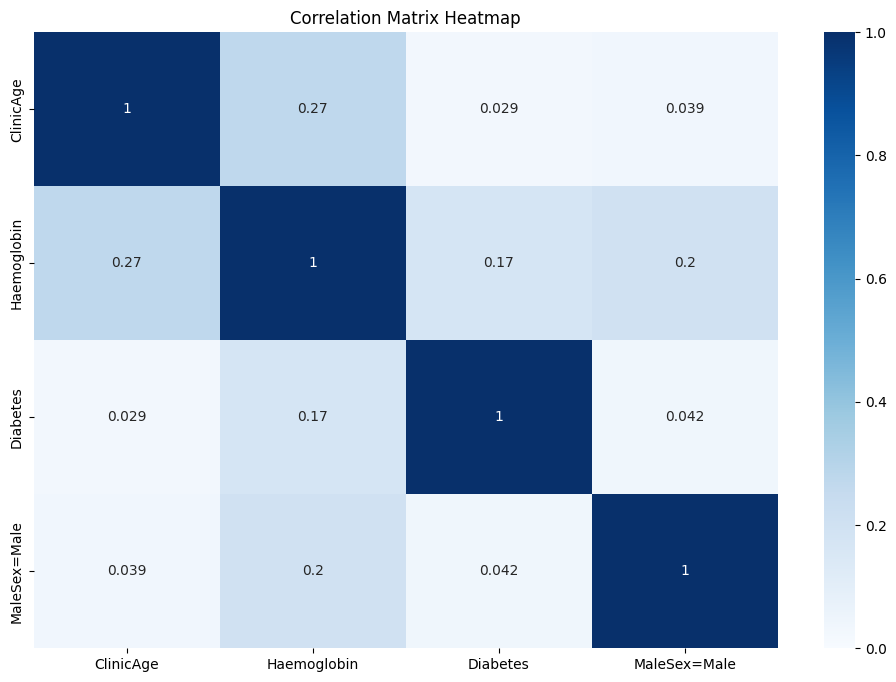

In [42]:
import seaborn as sns

# Create heatmap of all correlations
correlation=data_x_numeric4oh.corr().abs()
heatmap = sns.heatmap(correlation, vmin=0, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Correlation Matrix Heatmap')
plt.show()

In [43]:
# (de Kamps, 2022)
dfvis = OneHotEncoder().fit_transform(
    df[['ClinicAge', 'Haemoglobin', 'TimeDeath', 'StatusDeath', 'MaleSex']])
visdata = dfvis.to_numpy().T
print(visdata[4])

[1. 0. 1. ... 1. 1. 1.]


C:\Users\omarc\AppData\Roaming\Python\Python310\site-packages\sksurv\column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():


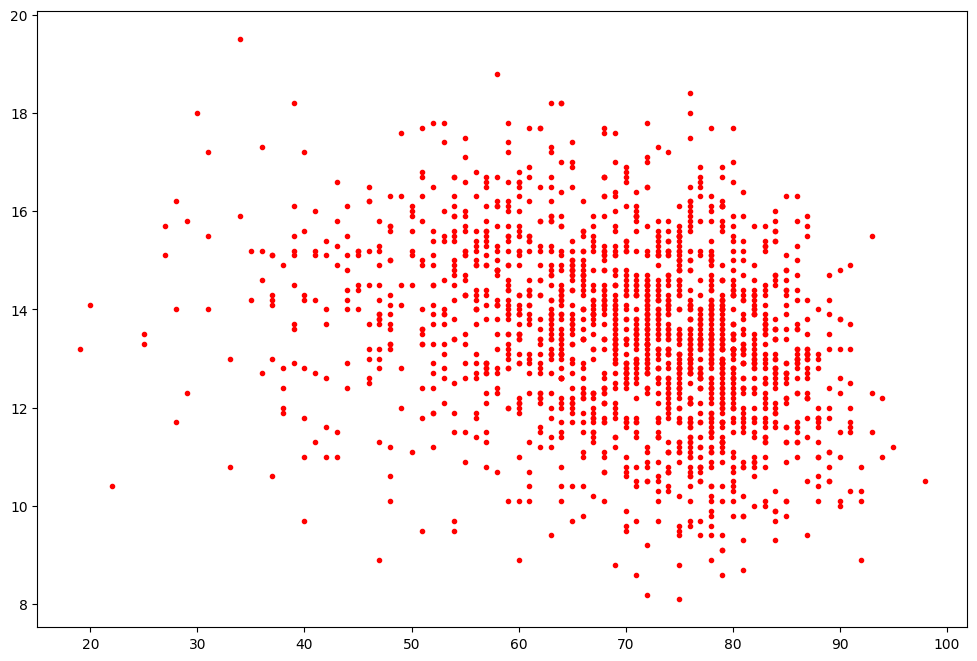

In [44]:
plt.plot(visdata[0],visdata[1],'r.')
plt.show()

In [45]:
# (de Kamps, 2022)
lifem = np.array([[x, y, t, g] for x, y, t, z, g in zip(
    visdata[0], visdata[1], visdata[2], visdata[3], visdata[4]) if z > 0 and g > 0]).T
deathm = np.array([[x, y, t, g] for x, y, t, z, g in zip(
    visdata[0], visdata[1], visdata[2], visdata[3], visdata[4]) if z < 1 and g > 0]).T

lifef = np.array([[x, y, t, g] for x, y, t, z, g in zip(
    visdata[0], visdata[1], visdata[2], visdata[3], visdata[4]) if z > 0 and g < 1]).T
deathf = np.array([[x, y, t, g] for x, y, t, z, g in zip(
    visdata[0], visdata[1], visdata[2], visdata[3], visdata[4]) if z < 1 and g < 1]).T

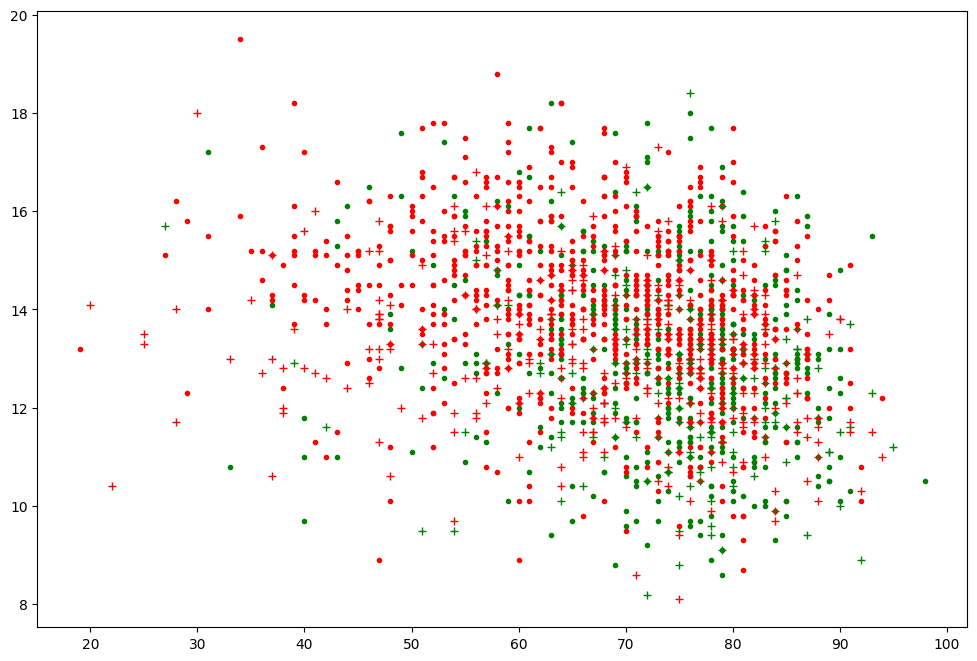

In [46]:
# (de Kamps, 2022)
plt.plot(lifem[0],  lifem[1],  'g.')
plt.plot(deathm[0], deathm[1], 'r.')

plt.plot(lifef[0],  lifef[1],  'g+')
plt.plot(deathf[0], deathf[1], 'r+')

plt.show()

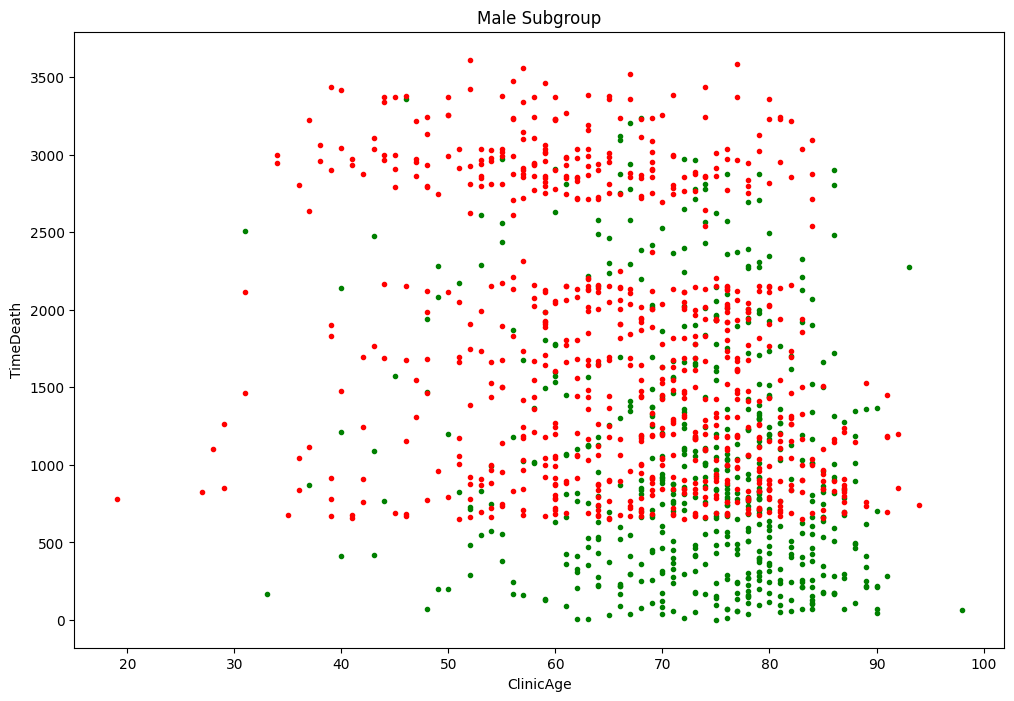

In [47]:
# (de Kamps, 2022)
plt.plot(lifem[0],  lifem[2],  'g.', label='censored')
plt.plot(deathm[0], deathm[2], 'r.', label='died')
plt.title('Male Subgroup')
plt.xlabel('ClinicAge')
plt.ylabel('TimeDeath')
plt.savefig('male.png')
plt.show()

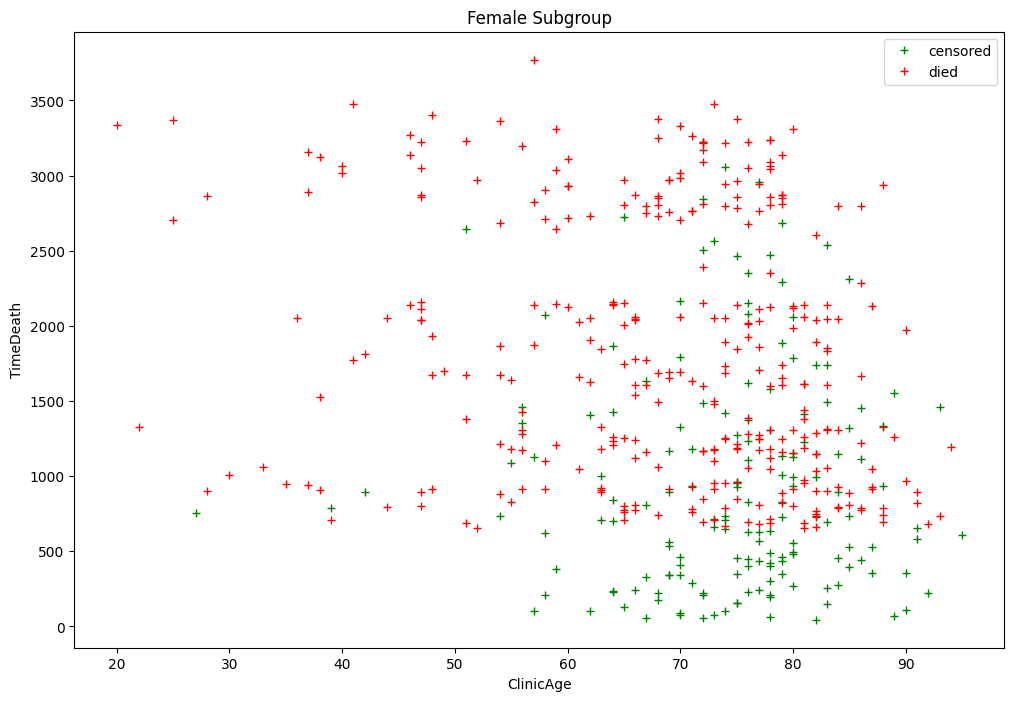

In [48]:
# (de Kamps, 2022)
plt.title('Female Subgroup')
plt.plot(lifef[0],  lifef[2],  'g+',label='censored')
plt.plot(deathf[0], deathf[2], 'r+',label='died')
plt.xlabel('ClinicAge')
plt.ylabel('TimeDeath')
plt.legend()
plt.savefig('female.png')
plt.show()

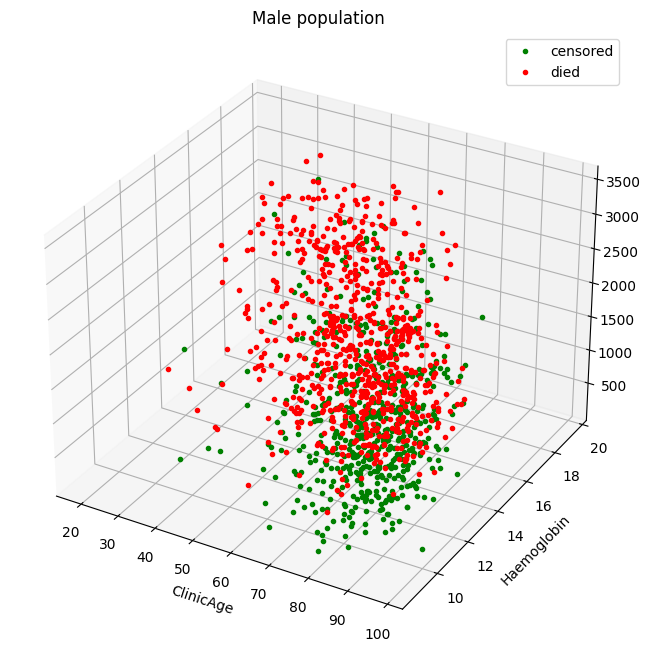

In [49]:
# (de Kamps, 2022)
fig = plt.figure()
ax = plt.axes(projection='3d')

plt.title('Male population')
plt.plot(lifem[0],  lifem[1],  lifem[2],   'g.',label='censored')
plt.plot(deathm[0], deathm[1], deathm[2], 'r.', label='died')
plt.xlabel('ClinicAge')
plt.ylabel('Haemoglobin')
#plt.zlabel('TimeDeath')
plt.legend()
plt.savefig('male3D.png')
plt.show()

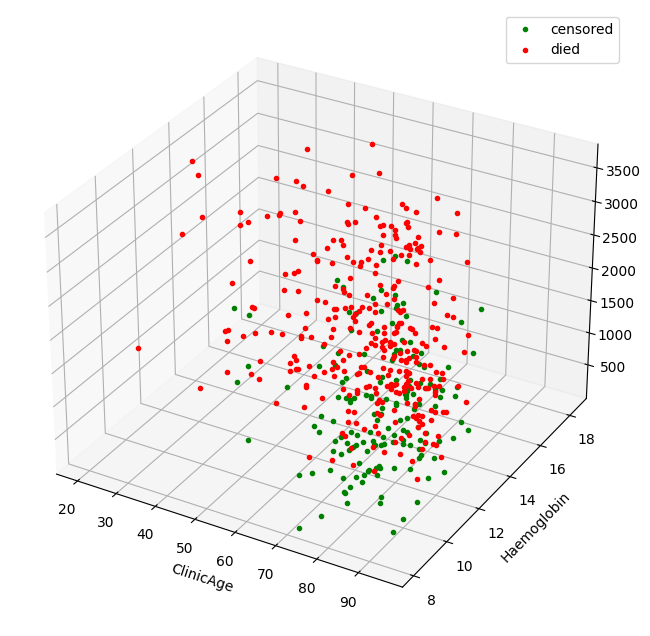

In [50]:
# (de Kamps, 2022)
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')

plt.plot(lifef[0],  lifef[1],  lifef[2],  'g.',label='censored')
plt.plot(deathf[0], deathf[1], deathf[2], 'r.',label='died')
plt.xlabel('ClinicAge')
plt.ylabel('Haemoglobin')
#plt.zlabel('TimeDeath')
plt.legend()
plt.show()

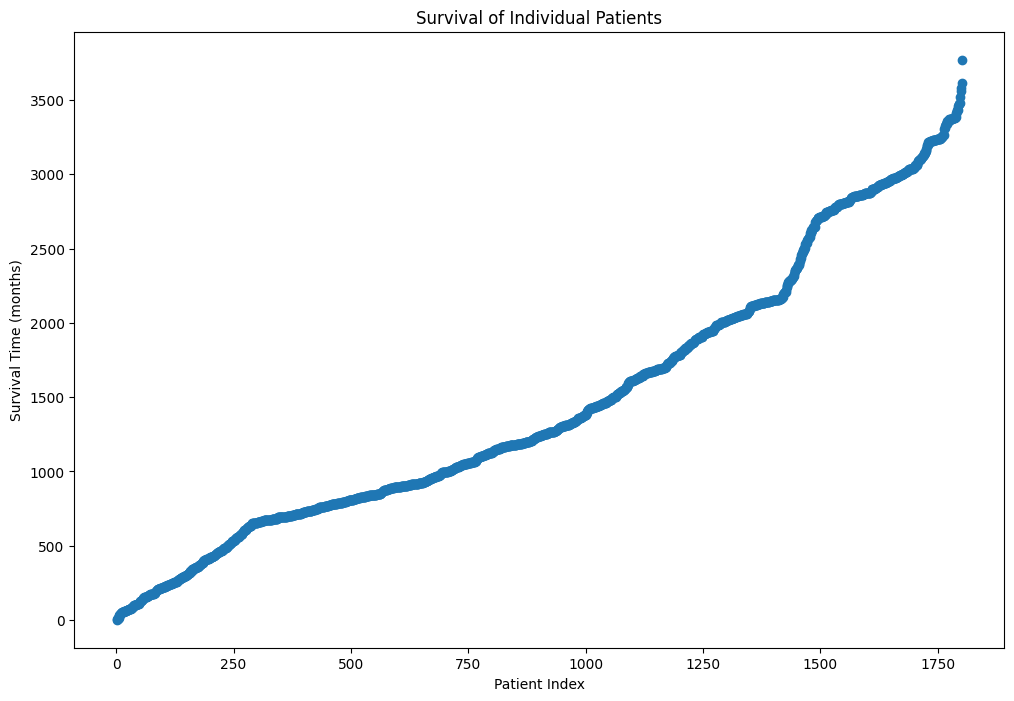

In [51]:
# Sort patients by death date ascending
df_sorted = df.sort_values(by=['TimeDeath'])

plt.scatter(range(1, len(df_sorted["TimeDeath"]) + 1), df_sorted["TimeDeath"])

# add axis labels and title
plt.xlabel('Patient Index')
plt.ylabel('Survival Time (months)')
plt.title('Survival of Individual Patients')

# display the plot
plt.show()

In [52]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn",
            "sksurv": "scikit-survival"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
            
        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

matplotlib==3.6.2
torch==2.0.0
numpy==1.23.5
pandas==1.5.2
seaborn==0.12.1
